# Tropical Cyclone Visualization

### Import Libraries

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as patches
import numpy as np
import pandas as pd 
import tropycal.tracks as tracks
import warnings
warnings.filterwarnings('ignore')

### Define functions

In [2]:
def LonTo360(dlon):
    # Convert longitudes to 0-360 deg
    dlon = ((360 + (dlon % 360)) % 360)
    return dlon

In [4]:
def get_by_name(name: str, year: int, ibtrack_file: str):
    data = pd.read_csv(ibtrack_file, low_memory=False)  
    data = data.iloc[1: , :] # remove the row of units
    year_date_of = pd.to_datetime(f'{year}')
    year_date_after = pd.to_datetime(f'{year+1}')
    data = data[data['NAME'] == name]
    data['ISO_TIME'] = pd.to_datetime(data['ISO_TIME'])
    mask = (data['ISO_TIME'] >= year_date_of) & (data['ISO_TIME'] < year_date_after)
    data = data[mask]
    extract_vars = ['NAME', 'ISO_TIME', 'WMO_WIND', 'WMO_PRES', 'LAT', 'LON', 
                    'USA_R34_NE', 'USA_R34_NW', 'USA_R34_SE', 'USA_R34_SW', 'USA_R50_NE', 'USA_R50_NW', 'USA_R50_SE', 'USA_R50_SW', 'USA_R64_NE', 'USA_R64_NW', 'USA_R64_SE', 'USA_R64_SW', 
                   'REUNION_R34_NE', 'REUNION_R34_NW', 'REUNION_R34_SE', 'REUNION_R34_SW', 'REUNION_R50_NE', 'REUNION_R50_NW', 'REUNION_R50_SE', 'REUNION_R50_SW', 'REUNION_R64_NE', 'REUNION_R64_NW', 'REUNION_R64_SE', 'REUNION_R64_SW',
                   'BOM_R34_NE', 'BOM_R34_SE', 'BOM_R34_NW', 'BOM_R34_SW', 'BOM_R50_NE', 'BOM_R50_SE', 'BOM_R50_NW', 'BOM_R50_SW', 'BOM_R64_NE', 'BOM_R64_SE', 'BOM_R64_NW', 'BOM_R64_SW']
    data = data[extract_vars]
    if year != 2021: 
        data = data[data['WMO_WIND'] != ' ']
        data = data[data['WMO_PRES'] != ' ']
    data['LON_180'] = data['LON']
    data['LON']=data['LON'].astype(float).apply(LonTo360)
    return data

In [6]:
def draw_quadrants_arcs(xcenter, ycenter, radii, lw=2, ec='crimson', ax=None):
#     ax = ax or plt.gca()
    for rad, theta in zip(radii, [0, 90, 180, 270]):
        arc = patches.Arc((xcenter, ycenter), 2*rad, 2*rad, theta1=theta, theta2=theta+90,
                              lw=lw, ec=ec, fc='none')
        ax.add_patch(arc)
    ax.hlines([ycenter, ycenter], [xcenter + radii[0], xcenter - radii[1]], [xcenter + radii[3], xcenter - radii[2]],
              lw=lw, colors=ec)
    ax.vlines([xcenter, xcenter], [ycenter + radii[0], ycenter - radii[2]], [ycenter + radii[1], ycenter - radii[3]],
              lw=lw, colors=ec)        

In [7]:
def draw_quadrants_wedges(xcenter, ycenter, radii, lw=2, ec='crimson', fc='lime', alpha=1, ax=None):
    ax = ax or plt.gca()
    for rad, theta in zip(radii, [0, 90, 180, 270]):
        wedge = patches.Wedge((xcenter, ycenter), rad, theta, theta + 90,
                              lw=lw, ec=ec, fc=fc, alpha=alpha)
        ax.add_patch(wedge)

### User Settings

In [8]:
### user settings ###
storm_name = 'IDA'
storm_year = 2021
ibtrack_file = 'ibtracs.ALL.list.v04r00.csv'

### Get Tropical Cyclone Data

In [11]:
result = get_by_name(storm_name, storm_year, ibtrack_file)
output_filename = f'{storm_name}_{storm_year}_track.png'

### Create Plot

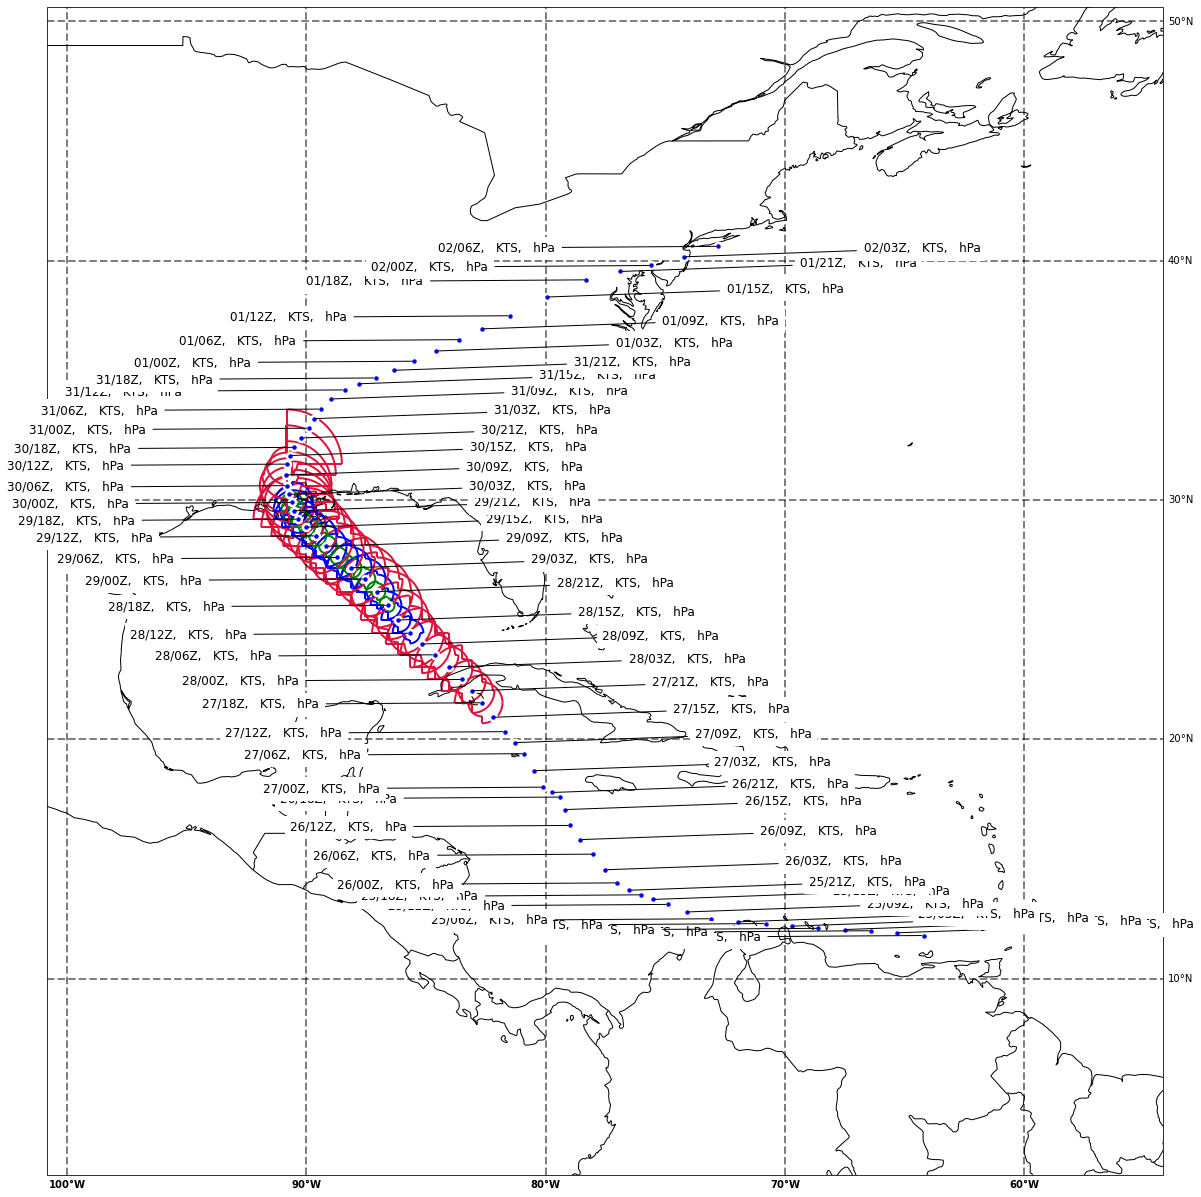

In [14]:
figure = plt.figure(figsize=(20,25))
ax = figure.add_subplot(1,1,1, projection=ccrs.PlateCarree())
# adds national borders
ax.add_feature(cfeature.BORDERS)
# add coastlines
ax.add_feature(cfeature.COASTLINE)
min_lat= result['LAT'].astype(float).min()
max_lat=result['LAT'].astype(float).max()
min_lon=result['LON'].astype(float).min()
max_lon=result['LON'].astype(float).max()
offset = 10.0 # how far away from the min/max lat/lon points you want the map to be
ax.set_extent([min_lon-offset,max_lon+offset,min_lat-offset,max_lat+offset], crs=ccrs.PlateCarree())
#ax.set_extent([255,115,0,60], crs=ccrs.PlateCarree())

# modify the plot by adding a scatterplot over the map
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=2, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl.xlabels_top = False
gl.ylabels_left = False
gl.ylabels_right=True
gl.xlines = True
lon_plot_range = [i for i in range(-180,190,10)]
lat_plot_range = [i for i in range(-80,90,10)]
gl.xlocator = mticker.FixedLocator(lon_plot_range)
gl.ylocator = mticker.FixedLocator(lat_plot_range)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'weight': 'bold'} # 'color': 'red', 

crs_latlon = ccrs.PlateCarree()

sign = 1


# loop through each time (row of the dataframe) of the hurricance
for i in range(len(result["LON"])):
    lon = float(result["LON"].iloc[i])
    lat = float(result["LAT"].iloc[i])
    at_x, at_y = ax.projection.transform_point(lon, lat,
                                               src_crs=crs_latlon)
    r34_se= result['USA_R34_SE'].iloc[i]
    r34_ne= result['USA_R34_NE'].iloc[i]
    r34_sw=result['USA_R34_SW'].iloc[i]
    r34_nw=result['USA_R34_NW'].iloc[i]
    
    if r34_se != ' ' and r34_ne != ' ' and r34_sw != ' ' and r34_nw != ' ':
        radii_34 = []
        radii_34.append(int(r34_se)/70)
        radii_34.append(int(r34_ne)/70)
        radii_34.append(int(r34_sw)/70)
        radii_34.append(int(r34_nw)/70)
        draw_quadrants_arcs(at_x, at_y, radii_34,ax=ax)
    
    r50_se= result['USA_R50_SE'].iloc[i]
    r50_ne= result['USA_R50_NE'].iloc[i]
    r50_sw=result['USA_R50_SW'].iloc[i]
    r50_nw=result['USA_R50_NW'].iloc[i]
    
    if r50_se != ' ' and r50_ne != ' ' and r50_sw != ' ' and r50_nw != ' ':
        radii_50 = []
        radii_50.append(int(r50_se)/70)
        radii_50.append(int(r50_ne)/70)
        radii_50.append(int(r50_sw)/70)
        radii_50.append(int(r50_nw)/70)
        draw_quadrants_arcs(at_x, at_y, radii_50, ec='blue',ax=ax)

    r64_se= result['USA_R64_SE'].iloc[i]
    r64_ne= result['USA_R64_NE'].iloc[i]
    r64_sw=result['USA_R64_SW'].iloc[i]
    r64_nw=result['USA_R64_NW'].iloc[i]
    
    if r64_se != ' ' and r64_ne != ' ' and r64_sw != ' ' and r64_nw != ' ':
        radii_64 = []
        radii_64.append(int(r64_se)/70)
        radii_64.append(int(r64_ne)/70)
        radii_64.append(int(r64_sw)/70)
        radii_64.append(int(r64_nw)/70)

        draw_quadrants_arcs(at_x, at_y, radii_64, ec='green',ax=ax)

    
    wind_pt = str(result["WMO_WIND"].iloc[i]) + " KTS" 
    pres_pt = str(result["WMO_PRES"].iloc[i]) + " hPa"
    time_pt = result["ISO_TIME"].iloc[i].strftime("%d/%H") + "Z"
    info_pt = time_pt + ", " + wind_pt + ", " + pres_pt
    
    plt.plot(lon, lat, marker='o', markersize=7.0, markeredgewidth=2.5,
             markerfacecolor='blue', markeredgecolor='white',
             transform=crs_latlon)
    sign = sign * -1
    x_textcoord = 180
    y_textcoord = 5
    if sign < 0:
        x_textcoord = -280
        y_textcoord = -5
    plt.annotate(
        info_pt, xy=(at_x, at_y), xytext=(x_textcoord, y_textcoord), textcoords='offset points',
        color='black', backgroundcolor='white', size='large',
        arrowprops=dict(arrowstyle='-', color='black', linewidth=1.0))
    
# plt.show()
plt.savefig(output_filename, bbox_inches='tight')